## Lab 12: AE3: Optymalizacja wag w sieci MLP z użyciem algorytmu genetycznego (1 tydzień, bez punktów, bo sprawozdanie)

Zaimplementować proste uczenie MLP z użyciem algorytmu genetycznego. 

Na wejściu jest: struktura sieci neuronowej i dane uczące. 

Optymalizowana funkcja to funkcja przekształcająca wektor wag sieci na błąd na zbiorze uczącym. 

Zastosować standardowe operatory krzyżowania i mutacji.

Przeprowadzić uczenie na zbiorach:
- iris https://archive.ics.uci.edu/ml/datasets/Iris
- multimodal-large (z części laboratorium o sieciach neuronowych)
- auto-mpg (przewidzieć wartość mpg) - http://archive.ics.uci.edu/ml/datasets/Auto+MPG

## TODO:
- implement genome
- implement population
- implement mutation
- implement crossover
- implement fitness function
- pack all together

# Implementation

In [1]:
import numpy as np
import pandas as pd
import copy
import random
import tqdm

In [2]:
# 6 is input size, 1 is output size
net_size = [2,10,10,1]

## Reading Data

### IRIS

In: 4

Out: 3

In [3]:
iris = pd.read_csv('data/iris.data', header=None)
iris.head(2)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


In [4]:
iris_y = pd.get_dummies(iris.iloc[:, 4].values).to_numpy()
iris_y[:3]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [5]:
iris_x = iris.iloc[:, [0,1,2,3]].to_numpy()
iris_x[:3]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

### Multimodal-large

In: 1

Out: 1

In [6]:
multimodal = pd.read_csv('data/multimodal-large-training.csv')
multimodal.head(2)

,x,y
0,-0.685726,-74.197483
1,-0.879898,-30.504177


In [7]:
multimodal_y = multimodal.iloc[:, 1].to_numpy().reshape((-1, 1))
multimodal_y[:3]

array([[-74.19748342],
       [-30.50417674],
       [ 10.75412185]])

In [8]:
multimodal_x = multimodal.iloc[:, 0].to_numpy().reshape((-1, 1))
multimodal_x[:3]

array([[-0.68572568],
       [-0.87989777],
       [ 1.41193195]])

### Auto-mpg

In: 7

Out: 1

In [9]:
autompg = pd.read_csv('data/auto-mpg.csv')
autompg.head(2)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320


In [10]:
sum(autompg.horsepower=='?') # 6 records have nans, will be removed

6

In [11]:
# drop rows that have ? in horsepower
autompg = autompg.loc[autompg.horsepower!='?',:]
autompg.loc[:,'horsepower'] = pd.to_numeric(autompg.loc[:,'horsepower'])

In [12]:
sum(autompg.horsepower=='?') # were removed

0

In [13]:
autompg_y = autompg.iloc[:, 0].to_numpy().reshape((-1, 1))
autompg_y[:3]

array([[18.],
       [15.],
       [18.]])

In [14]:
autompg_x = autompg.iloc[:, 1:-1].to_numpy()
autompg_x[:3]

array([[8.000e+00, 3.070e+02, 1.300e+02, 3.504e+03, 1.200e+01, 7.000e+01,
        1.000e+00],
       [8.000e+00, 3.500e+02, 1.650e+02, 3.693e+03, 1.150e+01, 7.000e+01,
        1.000e+00],
       [8.000e+00, 3.180e+02, 1.500e+02, 3.436e+03, 1.100e+01, 7.000e+01,
        1.000e+00]])

## Genome and population

A list of numpy matrices. Each matrix is a weight matrix for a layer.

In [15]:
genome = [np.random.randn(prev + int(layer!=0),nextt) for layer, (prev,nextt) in enumerate(zip(net_size[:-1],net_size[1:]))]
print("weights sizes (with bias added):",[x.shape for x in genome])
# genome

weights sizes (with bias added): [(2, 10), (11, 10), (11, 1)]


In [16]:
population_size = 20

In [17]:
def get_genome(net_shape):
    return [np.random.rand(prev + int(layer!=0),nextt) for layer, (prev,nextt) in enumerate(zip(net_shape[:-1],net_shape[1:]))]

def get_population(size, net_shape):
    return [get_genome(net_shape) for _ in range(size)]

population = get_population(population_size, net_size)
print("weights sizes (with bias added):",[x.shape for x in population[0]])
# population[0]


weights sizes (with bias added): [(2, 10), (11, 10), (11, 1)]


## Mutation

Gaussian, layer by layer, mutate if < `mutation_rate`.

In [18]:
def mutate_genome(genome, mutation_rate):
    weights_count = sum(x.size for x in genome)
    for _ in range(weights_count):
        layer = random.randint(0, len(genome)-1)
        row = random.randint(0, genome[layer].shape[0]-1)
        col = random.randint(0, genome[layer].shape[1]-1)
        if random.random() < mutation_rate:
            genome[layer][row][col] += random.uniform(-0.5, 0.5)
    return genome

def mutate_population(population, mutation_rate):
    return [mutate_genome(genome, mutation_rate) for genome in population]

## Crossover

layer by layer, swap whole layer if < `crossover_rate`.

In [19]:
def crossover_genomes(genome1, genome2, crossover_rate):
    weights_count = sum(x.size for x in genome1)
    new_genome = copy.deepcopy(genome1)
    for _ in range(weights_count):
        layer = random.randint(0, len(genome1)-1)
        # print("max row col:",genome1[layer].shape[0],genome1[layer].shape[1])
        row = random.randint(0, genome1[layer].shape[0]-1)
        col = random.randint(0, genome1[layer].shape[1]-1)
        # print(layer, row, col)
        if random.random() < crossover_rate:
            new_genome[layer][row][col] = genome2[layer][row][col]
    return new_genome

def crossover_population(population, crossover_rate):
    return [crossover_genomes(genome, random.choice(population), crossover_rate) for genome in population]

## Fitness function

MSE

In [20]:
def relu(x):
    return x * (x > 0)

def tanh(x):
    return np.tanh(x)

def linear(x):
    return x

def forward_prop(X, genome, activations):
    temp = activations[0](X.reshape((-1,X.shape[1])) @ genome[0])
    for i in range(1,len(genome)-1):
        temp = activations[i](np.hstack([np.ones((temp.shape[0],1)),temp]) @ genome[i])
    result = activations[-1](np.hstack([np.ones((temp.shape[0],1)),temp]) @ genome[-1])
    return result

In [21]:
def fitness_accuracy(X, y, genome, activations):
    predictions = forward_prop(X, genome, activations)
    return np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1))

def fitness_accuracy_population(X,y,population,activations):
    return [fitness_accuracy(X,y,genome,activations) for genome in population]

def fitness_mse(X, y, genome, activations):
    predictions = forward_prop(X, genome, activations)
    return np.mean(np.power(predictions - y, 2))

def fitness_mse_population(X,y,population,activations):
    return [fitness_mse(X,y,genome,activations) for genome in population]

## Tournament selection

copied from previous labs

In [22]:
from operator import itemgetter 

def tournament_min(population,scores,tournament_size):
    population_size = len(population)
    selected = np.array([i for i in range(population_size)])
    selected[0] = np.argmin(scores)
    for i,selected_id in enumerate(selected):
        for new_id in np.random.choice(population_size,size=tournament_size,replace=True):
            if scores[selected_id] > scores[new_id]:
                selected[i] = new_id
    selected = selected.astype(np.int64)
    return list(itemgetter(*selected)(population))

def tournament_max(population,scores,tournament_size):
    return tournament_min(population,[-s for s in scores],tournament_size)

# Results

## IRIS

In [68]:
population_size = 30
tournament_size = 3
epochs = 3000
crossover_rate = 0.4
mutation_rate = 0.2

net_size = [4,6,5,3]
activations = [relu,relu,relu]

X = iris_x
y = iris_y

population = get_population(population_size, net_size)
best_solution, best_score = 0, 10**20
best_scores_history = []
avg_scores_history = []
best_accuracy_history = []
avg_accuracy_history = []
progress_bar = tqdm.tqdm(range(epochs), desc="Training...")
for epoch in progress_bar:
    population = crossover_population(population, crossover_rate)
    population = mutate_population(population, mutation_rate)
    scores = fitness_mse_population(X=X, y=y, population=population, activations=activations)
    population = tournament_min(population,scores,tournament_size)
    if np.min(scores) < best_score:
        best_solution, best_score = copy.deepcopy(population[np.argmin(scores)]), np.min(scores)
        best_acc = fitness_accuracy(X=X, y=y, genome=population[np.argmin(scores)], activations=activations)
    if epoch % 100 == 0:
        progress_bar.set_postfix({"best MSE": best_score,"best acc": best_acc, "current avg MSE": np.average(scores), "curr accuracy": fitness_accuracy(X=X, y=y, genome=population[np.argmin(scores)], activations=activations)})
    best_scores_history.append(np.min(scores))
    avg_scores_history.append(np.average(scores))
    best_accuracy_history.append(best_acc)
    avg_accuracy_history.append(np.average(fitness_accuracy_population(X=X, y=y, population=population, activations=activations)))
print(f"Best solution score MSE: {best_score}")
print(f"Best solution score accuracy: {best_acc}")

import copy
solution_iris = copy.deepcopy(best_solution)

Training...: 100%|██████████| 3000/3000 [01:19<00:00, 37.89it/s, best MSE=0.0244, best acc=0.967, current avg MSE=0.132, curr accuracy=0.973]

Best solution score MSE: 0.023156657915522634
Best solution score accuracy: 0.9866666666666667


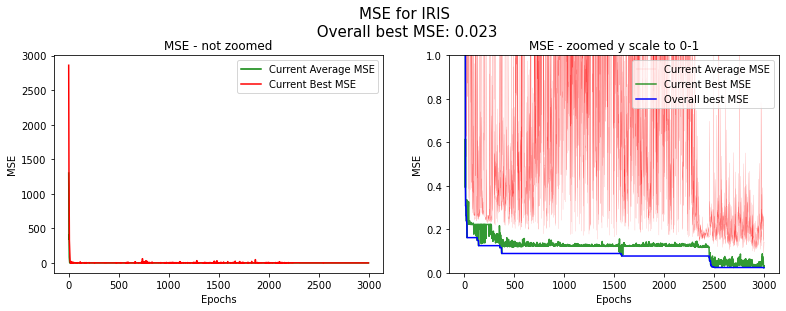

In [69]:
import matplotlib.pyplot as plt

fig1, (ax1,ax2) = plt.subplots(1,2, figsize=(13,4))


ax1.plot(best_scores_history, label="Current Average MSE", color="green")
ax1.plot(avg_scores_history, label="Current Best MSE", color="red")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("MSE")
ax1.legend()
ax1.set_title("MSE - not zoomed")

ax2.plot(avg_scores_history, label="Current Average MSE", color="red", linewidth=0.1)
ax2.plot(best_scores_history, label="Current Best MSE", color="green", alpha=0.8)
ax2.plot([min(best_scores_history[:i+1]) for i in range(len(best_scores_history)-1)], label="Overall best MSE", color="blue")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("MSE")
ax2.set_ylim(0,1)
ax2.legend()
ax2.set_title("MSE - zoomed y scale to 0-1")
plt.suptitle("MSE for IRIS\n Overall best MSE: " + str(round(best_score,3)), y=1.05, size=15)
plt.show()

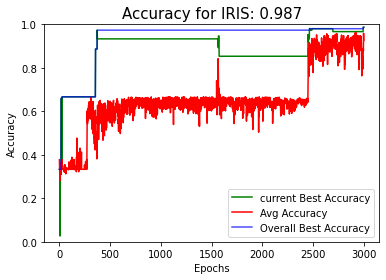

In [70]:
import matplotlib.pyplot as plt
plt.plot(best_accuracy_history, label="current Best Accuracy", color="green")
plt.plot(avg_accuracy_history, label="Avg Accuracy", color="red")
plt.plot([max(best_accuracy_history[:i+1]) for i in range(0,len(best_scores_history)-1)], label="Overall Best Accuracy", color="blue", alpha=0.7)
plt.legend()
plt.title("Accuracy for IRIS: " + str(round(best_acc,3)), size=15)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(bottom=0, top=1);

## Multimodal large

In [56]:
population_size = 20
tournament_size = 3
epochs = 3000
crossover_rate = 0.4
mutation_rate = 0.2

net_size = [1,10,7,1]
activations = [tanh, tanh, tanh, linear]

X = multimodal_x
y = multimodal_y


# taking subset
subset_size = 500
selection = np.random.choice(len(y),size=subset_size,replace=False)
X = X[selection]
y = y[selection]

population = get_population(population_size, net_size)
best_solution, best_score = 0, 10**20
best_scores_history = []
avg_scores_history = []
best_accuracy_history = []
avg_accuracy_history = []
progress_bar = tqdm.tqdm(range(epochs), desc="Training...")
for epoch in progress_bar:
    population = crossover_population(population, crossover_rate)
    population = mutate_population(population, mutation_rate)
    scores = fitness_mse_population(X=X, y=y, population=population, activations=activations)
    population = tournament_min(population,scores,tournament_size)
    if np.min(scores) < best_score:
        best_solution, best_score = copy.deepcopy(population[np.argmin(scores)]), np.min(scores)
    progress_bar.set_postfix({"best MSE": best_score, "current avg MSE": np.average(scores)})
    best_scores_history.append(np.min(scores))
    avg_scores_history.append(np.average(scores))
print(f"Best solution score MSE: {best_score}")

import copy
solution_multimodal = copy.deepcopy(best_solution)

Training...: 100%|██████████| 3000/3000 [01:48<00:00, 27.77it/s, best MSE=896, current avg MSE=1.8e+3]     

Best solution score MSE: 896.2619817812907


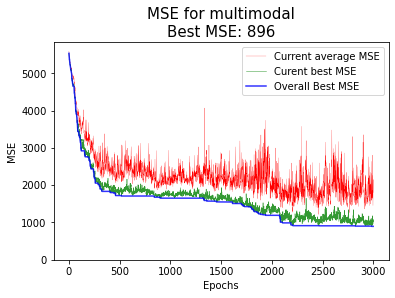

In [57]:
import matplotlib.pyplot as plt
plt.plot(avg_scores_history, label="Current average MSE", color="red", linewidth=0.2)
plt.plot(best_scores_history, label="Curent best MSE", color="green", alpha=0.8, linewidth=0.5)
plt.plot([min(best_scores_history[:i+1]) for i in range(0,len(best_scores_history)-1)], label="Overall Best MSE", color="blue", alpha=0.8)
plt.legend()
plt.title("MSE for multimodal\nBest MSE: "+ str(round(best_score)), size=15)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.ylim(bottom=0);

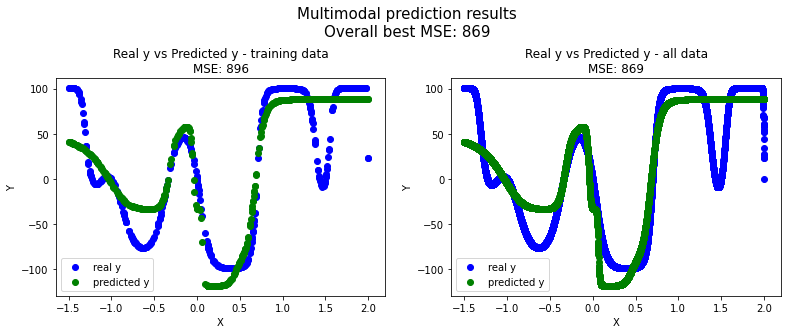

In [58]:
def plot_compare_predicted_real(net, x_part, y_part, x_train,y_train,activations):
    xmin = min(x_train) *1.1
    xmax = max(x_train) *1.1

    fig1, (ax1,ax2) = plt.subplots(1,2, figsize=(13,4))

    ax1.scatter(x_part, y_part, color="blue",label="real y")
    ax1.scatter(x_part, forward_prop(x_part, net,activations), color="green",label="predicted y")
    ax1.legend()
    ax1.set_xlim(xmin, xmax)
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_title("Real y vs Predicted y - training data\nMSE: " + str(round(fitness_mse(X=x_part, y=y_part, genome=net, activations=activations))))

    ax2.scatter(x_train, y_train, color="blue",label="real y")
    ax2.scatter(x_train, forward_prop(x_train, net,activations), color="green",label="predicted y")
    ax2.set_xlim(xmin, xmax)
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_title("Real y vs Predicted y - all data\nMSE: " + str(round(fitness_mse(X=x_train, y=y_train, genome=net, activations=activations))))
    ax2.legend()

    plt.suptitle("Multimodal prediction results\nOverall best MSE: " + str(round(fitness_mse(X=multimodal_x, y=multimodal_y, genome=net, activations=activations))), y=1.13, size=15)
    plt.show()

plot_compare_predicted_real(solution_multimodal, X, y, multimodal_x, multimodal_y, activations)


## MPG

In [43]:
population_size = 50
tournament_size = 3
epochs = 1500
crossover_rate = 0.4
mutation_rate = 0.2

net_size = [7,6,5,1]
activations = [tanh, tanh, tanh, linear]

X = autompg_x
y = autompg_y

population = get_population(population_size, net_size)
best_solution, best_score = 0, 10**20
best_scores_history = []
avg_scores_history = []
best_accuracy_history = []
avg_accuracy_history = []
progress_bar = tqdm.tqdm(range(epochs), desc="Training...")
for epoch in progress_bar:
    population = crossover_population(population, crossover_rate)
    population = mutate_population(population, mutation_rate)
    scores = fitness_mse_population(X=X, y=y, population=population, activations=activations)
    population = tournament_min(population,scores,tournament_size)
    if np.min(scores) < best_score:
        best_solution, best_score = copy.deepcopy(population[np.argmin(scores)]), np.min(scores)
    progress_bar.set_postfix({"best MSE": best_score, "current avg MSE": np.average(scores)})
    best_scores_history.append(np.min(scores))
    avg_scores_history.append(np.average(scores))
print(f"Best solution score MSE: {best_score}")

import copy
solution_auto = copy.deepcopy(best_solution)

Training...: 100%|██████████| 1500/1500 [01:11<00:00, 21.12it/s, best MSE=20.1, current avg MSE=38.2]

Best solution score MSE: 20.082197488014817


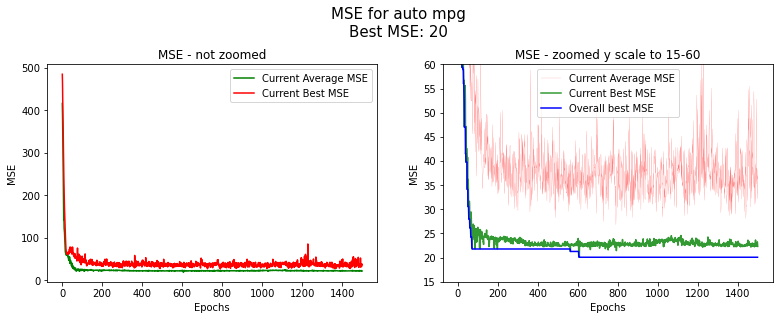

In [53]:
import matplotlib.pyplot as plt

fig1, (ax1,ax2) = plt.subplots(1,2, figsize=(13,4))


ax1.plot(best_scores_history, label="Current Average MSE", color="green")
ax1.plot(avg_scores_history, label="Current Best MSE", color="red")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("MSE")
ax1.legend()
ax1.set_title("MSE - not zoomed")

ax2.plot(avg_scores_history, label="Current Average MSE", color="red", linewidth=0.1)
ax2.plot(best_scores_history, label="Current Best MSE", color="green", alpha=0.8)
ax2.plot([min(best_scores_history[:i+1]) for i in range(len(best_scores_history)-1)], label="Overall best MSE", color="blue")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("MSE")
ax2.set_ylim(15,60)
ax2.legend()
ax2.set_title("MSE - zoomed y scale to 15-60")
plt.suptitle("MSE for auto mpg\nBest MSE: " + str(round(best_score)), y=1.08, size=15)
plt.show()

## Summary

Solutions to all problems were found. 

For every task, after running genetic algorithm, the scores for best networks were printed. The results are:
 - Iris - accuracy 0.987, MSE 0.023
 - multimodal - MSE 896 on train, MSE 869 on all data
 - auto mpg - MSE 20
 
Sometimes, iris got stuck at 0.67. 

Probabilities used for all tasks:
 - mutation: 0.2
 - crossover: 0.4

Execution times:
- iris: 80s
- multimodal: 110s
- autompg: 70s

Parameters for iris:
- population_size = 30
- tournament_size = 3
- epochs = 3000
- crossover_rate = 0.4
- mutation_rate = 0.2
- net_size = [4,6,5,3]
- activations = [relu,relu,relu]
 
Parameters for multimodal:
- population_size = 20
- tournament_size = 3
- epochs = 3000
- crossover_rate = 0.4
- mutation_rate = 0.2
- net_size = [1,10,7,1]
- activations = [tanh, tanh, tanh, linear]
- subset_size = 500

Parameters for auto mpg:
- population_size = 50
- tournament_size = 3
- epochs = 1500
- crossover_rate = 0.4
- mutation_rate = 0.2
- net_size = [7,6,5,1]
- activations = [tanh, tanh, tanh, linear]